In [1]:
from captum.attr import *
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Liberation Serif'

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("COVIDiSTRESS_April_May_Combined.csv", encoding= 'unicode_escape')
df = df.drop(["Unnamed: 0", "1", "Uninformative response", "PSS10_avg"], axis="columns")
features = list(df.columns)

In [4]:
class StressNN(nn.Module):
    def __init__(self, input_size = 54):
        super(StressNN, self).__init__()
        self.LinBlock = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.LinBlock(x)
        x = torch.sigmoid(x)
        return x

In [5]:
model = StressNN(df.shape[1])
model.load_state_dict(torch.load("var/model_april_may_mse.pt"))
model = model.to(DEVICE)

In [6]:
svs = ShapleyValueSampling(model)

In [7]:
world = torch.from_numpy(df.to_numpy()).type(torch.FloatTensor).to(DEVICE)
f_imp = svs.attribute(world, target=0, show_progress=True).mean(axis=0).cpu()

Shapley Value Sampling attribution: 100%|██████████| 1351/1351 [00:17<00:00, 78.91it/s]


In [8]:
imp_df = pd.DataFrame().from_dict({
    "Features": features,
    "Importance": f_imp,
    "Absolute Importance": torch.abs(f_imp),
    "Direction": f_imp/torch.abs(f_imp)
})
imp_df.sort_values("Absolute Importance", inplace=True)
imp_df["Direction"] = imp_df["Direction"].apply(lambda x: "teal" if x==1 else "crimson")

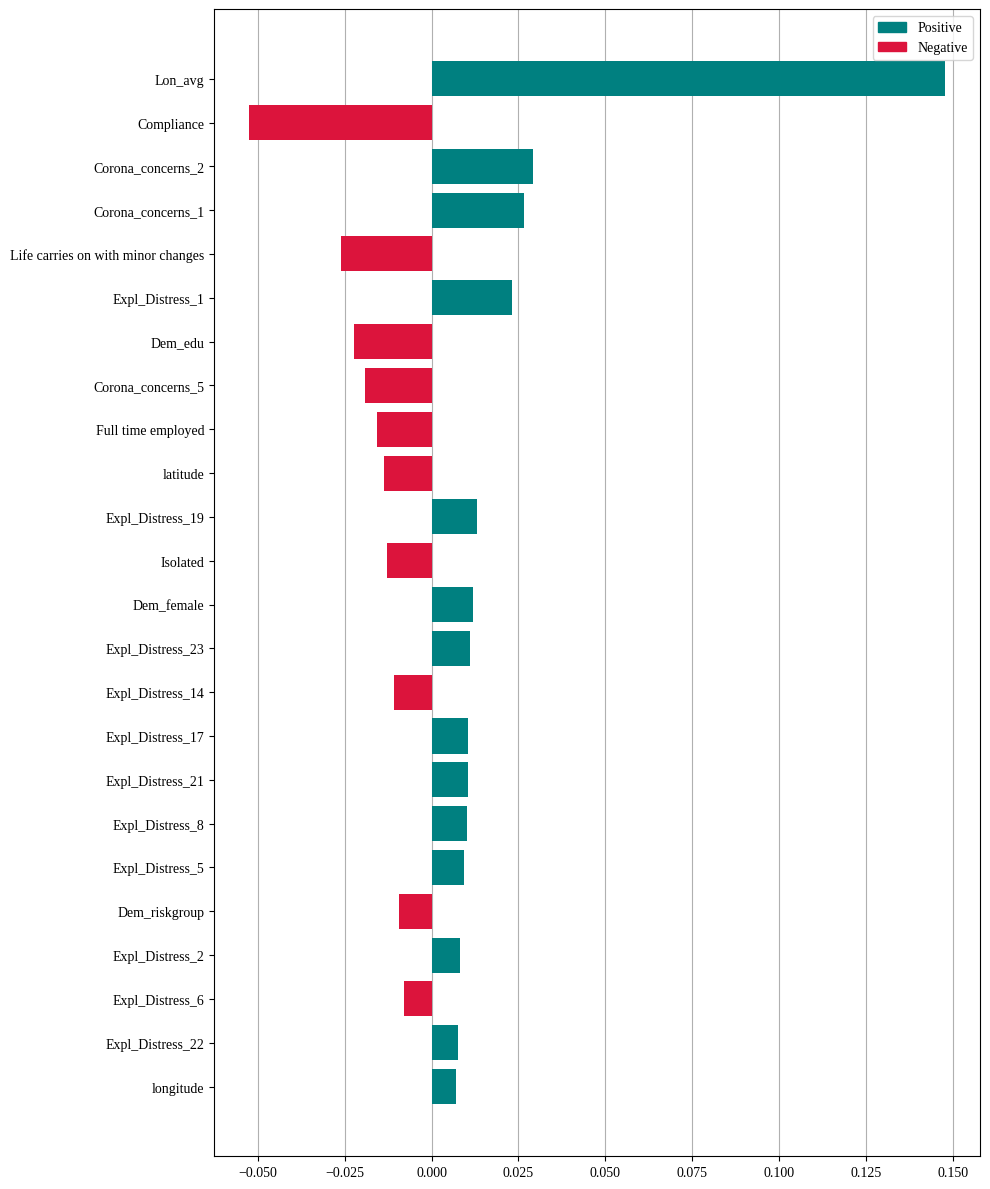

In [9]:
fig = plt.figure(figsize=(10, 12))
imp_df = imp_df.iloc[-24:, :]
plt.barh(imp_df["Features"], imp_df["Importance"], color=imp_df["Direction"], zorder=2)
plt.grid(axis="x", zorder=1, which="major")
plt.legend([plt.Rectangle((0,0),1,1, color="teal"), plt.Rectangle((0,0),1,1, color="crimson")], ["Positive", "Negative"])
plt.tight_layout()
plt.savefig("resources/world_importance_nn.png", dpi=300)
plt.show()